# ResNet50图像分类

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r1.8/tutorials/application/zh_cn/cv/mindspore_resnet50.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r1.8/tutorials/application/zh_cn/cv/mindspore_resnet50.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/r1.8/tutorials/application/source_zh_cn/cv/resnet50.ipynb)

图像分类是最基础的计算机视觉应用，属于有监督学习类别，如给定一张图像(猫、狗、飞机、汽车等等)，判断图像所属的类别。本章将介绍使用ResNet50网络对CIFAR-10数据集进行分类。

## ResNet网络介绍

ResNet50网络是2015年由微软实验室的何恺明提出，获得ILSVRC2015图像分类竞赛第一名。在ResNet网络提出之前，传统的卷积神经网络都是将一系列的卷积层和池化层堆叠得到的，但当网络堆叠到一定深度时，就会出现退化问题。下图是在CIFAR-10数据集上使用56层网络与20层网络训练误差和测试误差图，由图中数据可以看出，56层网络比20层网络训练误差和测试误差更大，随着网络的加深，其误差并没有如预想的一样减小。

![resnet-1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/resnet_1.png)

ResNet网络提出了残差网络结构(Residual Network)来减轻退化问题，使用ResNet网络可以实现搭建较深的网络结构（突破1000层）。论文中使用ResNet网络在CIFAR-10数据集上的训练误差与测试误差图如下图所示，图中虚线表示训练误差，实线表示测试误差。由图中数据可以看出，ResNet网络层数越深，其训练误差和测试误差越小。

![resnet-4](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/resnet_4.png)

> 了解ResNet网络更多详细内容，参见[ResNet论文](https://arxiv.org/pdf/1512.03385.pdf)。

## 数据集准备与加载

[CIFAR-10数据集](http://www.cs.toronto.edu/~kriz/cifar.html)共有60000张32*32的彩色图像，分为10个类别，每类有6000张图，数据集一共有50000张训练图片和10000张评估图片。如下示例使用`mindvision.classification.dataset.Cifar10`接口下载并加载CIFAR-10数据集。

In [2]:
from mindvision.classification.dataset import Cifar10

# 数据集根目录
data_dir = "./datasets"

# 下载解压并加载CIFAR-10训练数据集
dataset_train = Cifar10(path=data_dir, split='train', batch_size=6, resize=32, download=True)
ds_train = dataset_train.run()
step_size = ds_train.get_dataset_size()
# 下载解压并加载CIFAR-10测试数据集
dataset_val = Cifar10(path=data_dir, split='test', batch_size=6, resize=32, download=True)
ds_val = dataset_val.run()

[WARNING] ME(71352:4552414720,MainProcess):2022-10-11-14:13:41.171.571 [mindspore/dataset/core/validator_helpers.py:804] 'RandomCrop' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomCrop' from mindspore.dataset.vision instead.
[WARNING] ME(71352:4552414720,MainProcess):2022-10-11-14:13:41.172.622 [mindspore/dataset/core/validator_helpers.py:804] 'RandomHorizontalFlip' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomHorizontalFlip' from mindspore.dataset.vision instead.
[WARNING] ME(71352:4552414720,MainProcess):2022-10-11-14:13:41.173.352 [mindspore/dataset/core/validator_helpers.py:804] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(71352:4552414720,MainProcess):2022-10-11-14:13:41.174.503 [m

In [ ]:
from typing import Optional, Callable, Union, Tuple, Dict, List
import pathlib
import os
import mindspore.dataset.vision.c_transforms as transforms

class ParseCifar10(ParseDataset):
    """
    DownLoad and parse Cifar10 dataset.
    """
    url_path = {"path": "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz",
                "md5": "c58f30108f718f92721af3b95e74349a"}
    base_dir = "cifar-10-batches-py"
    classes_key = "label_names"

    extract = {
        "train": [
            ("data_batch_1", "c99cafc152244af753f735de768cd75f"),
            ("data_batch_2", "d4bba439e000b95fd0a9bffe97cbabec"),
            ("data_batch_3", "54ebc095f3ab1f0389bbae665268c751"),
            ("data_batch_4", "634d18415352ddfa80567beed471001a"),
            ("data_batch_5", "482c414d41f54cd18b22e5b47cb7c3cb"),
        ],
        "test": [
            ("test_batch", "40351d587109b95175f43aff81a1287e")
        ],
        "meta": [
            ("batches.meta", "5ff9c542aee3614f3951f8cda6e48888")
        ]
    }

    def download_and_extract_archive(self):
        """Download the Cifar10 dataset if it doesn't exists."""
        path = os.path.split(self.path)[0]
        bool_list = []
        # Check whether the file exists and check value of md5.
        for value in self.extract.values():
            for i in value:
                filename, md5 = i[0], i[1]
                file_path = os.path.join(path, self.base_dir, filename)
                bool_list.append(
                    os.path.isfile(file_path) and self.download.check_md5(file_path, md5)
                )

        if all(bool_list):
            return

        # download files
        self.download.download_and_extract_archive(self.url_path["path"],
                                                   download_path=path,
                                                   md5=self.url_path["md5"])

    def __load_meta(self):
        """Load meta file."""
        meta_file = self.extract["meta"][0][0]
        meta_md5 = self.extract["meta"][0][1]
        meta_path = os.path.join(os.path.split(self.path)[0], self.base_dir, meta_file)

        if not os.path.isfile(meta_path) and self.download.check_md5(meta_path, meta_md5):
            raise RuntimeError(
                "Metadata file not found or check md5 value is incorrect. You can set download=True.")

        with open(meta_path, "rb") as f:
            data = pickle.load(f, encoding="latin1")
            classes = data[self.classes_key]
            index2label = {i: v for i, v in enumerate(classes)}
            return index2label

    def __load_cifar_batch(self):
        """Load single batch of cifar."""
        if not os.path.isfile(self.data_path) and self.download.check_md5(self.data_path, self.md5):
            raise RuntimeError(
                "Dataset file not found or check md5 value is incorrect. You can set download=True.")
        with open(self.data_path, "rb") as f:
            data_dict = pickle.load(f, encoding="latin1")

        data = data_dict["data"]
        labels = data_dict["labels"] if "labels" in data_dict else data_dict["fine_labels"]

        data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        labels = np.array(labels, dtype=np.int32)

        return data, labels

    def parse_dataset(self):
        """Parse data from Cifar10 dataset file."""
        data_list = []
        labels_list = []
        file_list = self.extract[os.path.basename(self.path)]
        self.index2label = self.__load_meta()

        for file_name, md5 in file_list:
            self.data_path = os.path.join(os.path.split(self.path)[0], self.base_dir, file_name)
            self.md5 = md5
            data, labels = self.__load_cifar_batch()
            data_list.append(data)
            labels_list.append(labels)

        data = np.concatenate(data_list, axis=0)
        labels = np.concatenate(labels_list, axis=0)

        return data, labels


class Cifar10():
    """build Cifar10 dataset"""

    def __init__(self,
                 path: str,
                 split: str = "train",
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 batch_size: int = 32,
                 repeat_num: int = 1,
                 shuffle: Optional[bool] = None,
                 num_parallel_workers: int = 1,
                 num_shards: Optional[int] = None,
                 shard_id: Optional[int] = None,
                 resize: Union[int, Tuple[int, int]] = 224,
                 download: bool = False):

        if not split
    
        super(Cifar10, self).__init__(path=path,
                                        split=split,
                                        load_data=load_data,
                                        transform=transform,
                                        target_transform=target_transform,
                                        batch_size=batch_size,
                                        repeat_num=repeat_num,
                                        resize=resize,
                                        shuffle=shuffle,
                                        num_parallel_workers=num_parallel_workers,
                                        num_shards=num_shards,
                                        shard_id=shard_id,
                                        download=download)
    


    def read_dataset(path: str) -> Tuple[List[str], List[int]]:
        """
        Get the path list and index list of images.
        """
        img_list = list()
        id_list = list()
        image_format = (
        '.JPEG',
        '.jpeg',
        '.PNG',
        '.png',
        '.JPG',
        '.jpg',
        '.PPM',
        '.ppm',
        '.BMP',
        '.bmp',
        '.PGM',
        '.pgm',
        '.WEBP',
        '.webp',
        '.TIF',
        '.tif',
        '.TIFF',
        '.tiff')

        idx = 0
        if os.path.isdir(path):
            for img_name in os.listdir(path):
                if pathlib.Path(img_name).suffix in image_format:
                    img_path = os.path.join(path, img_name)
                    img_list.append(img_path)
                    id_list.append(idx)
                    idx += 1
        else:
            img_list.append(path)
            id_list.append(idx)
        return img_list, id_list

    def run(self):
        """Dataset pipeline."""
        self.transforms()
        self.dataset = self.dataset.batch(self.batch_size, drop_remainder=True)
        self.dataset = self.dataset.repeat(self.repeat_num)

        return self.dataset

    



class Cifar10(Dataset):
    """
    The directory structure of Cifar10 dataset looks like:

        ./
        └── cifar-10-batches-py
             ├── data_batch_1
             ├── data_batch_2
             ├── data_batch_3
             ├── data_batch_4
             ├── data_batch_5
             ├── test_batch
             ├── readme.html
             └── batches.meta

    Args:
        path (string): Root directory of the Mnist dataset or inference image.
        split (str): The dataset split, supports "train", "test", or "infer". Default: "train".
        transform (callable, optional): A function transform that takes in a image. Default:None.
        target_transform (callable, optional): A function transform that takes in a label. Default:None.
        batch_size (int): Batch size of dataset. Default:32.
        repeat_num (int): The repeat num of dataset. Default:1.
        shuffle (bool, optional): Whether or not to perform shuffle on the dataset. Default:None.
        num_parallel_workers (int): Number of subprocess used to fetch the dataset in parallel.Default: 1.
        num_shards (int, optional): Number of shards that the dataset will be divided into. Default: None.
        shard_id (int, optional): The shard ID within num_shards. Default: None.
        resize (int, tuple): The output size of the resized image. If size is an integer, the smaller edge of the
        image will be resized to this value with the same image aspect ratio. If size is a sequence of length 2,
        it should be (height, width). Default: 224.
        download (bool) : Whether to download the dataset. Default: False.
    """

    def __init__(self,
                 path: str,
                 split: str = "train",
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 batch_size: int = 32,
                 repeat_num: int = 1,
                 shuffle: Optional[bool] = None,
                 num_parallel_workers: int = 1,
                 num_shards: Optional[int] = None,
                 shard_id: Optional[int] = None,
                 resize: Union[int, Tuple[int, int]] = 224,
                 download: bool = False):

        if split != "infer":
            self.parse_cifar10 = ParseCifar10(path=os.path.join(path, split))
            load_data = self.parse_cifar10.parse_dataset
        else:
            load_data = read_dataset

        super(Cifar10, self).__init__(path=path,
                                      split=split,
                                      load_data=load_data,
                                      transform=transform,
                                      target_transform=target_transform,
                                      batch_size=batch_size,
                                      repeat_num=repeat_num,
                                      resize=resize,
                                      shuffle=shuffle,
                                      num_parallel_workers=num_parallel_workers,
                                      num_shards=num_shards,
                                      shard_id=shard_id,
                                      download=download)

    @property
    def index2label(self):
        """Get the mapping of indexes and labels."""
        return self.parse_cifar10.index2label

    def download_dataset(self):
        """Download the Cifar10 data if it doesn't exist already."""
        if self.split == "infer":
            raise ValueError("Download is not supported for infer.")
        self.parse_cifar10.download_and_extract_archive()

    def default_transform(self):
        """Set the default transform for Cifar10 dataset."""
        trans = []
        if self.split == "train":
            trans += [
                transforms.RandomCrop((32, 32), (4, 4, 4, 4)),
                transforms.RandomHorizontalFlip(prob=0.5)
            ]

        trans += [
            transforms.Resize(self.resize),
            transforms.Rescale(1.0 / 255.0, 0.0),
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
            transforms.HWC2CHW()
        ]

        return trans

首先将数据集下载到指定目录下并解压，目前仅支持解析二进制版本的CIFAR-10文件（CIFAR-10 binary version）
    
下载后的数据集目录结构如下：

```Text

./datasets-cifar10
├── batches.meta.text
├── data_batch_1.bin
├── data_batch_2.bin
├── data_batch_3.bin
├── data_batch_4.bin
├── data_batch_5.bin
├── readme.html
└── test_batch.bin


```

对CIFAR-10训练数据集进行可视化。

Image shape: (6, 3, 32, 32), Label: [9 7 6 8 3 6]


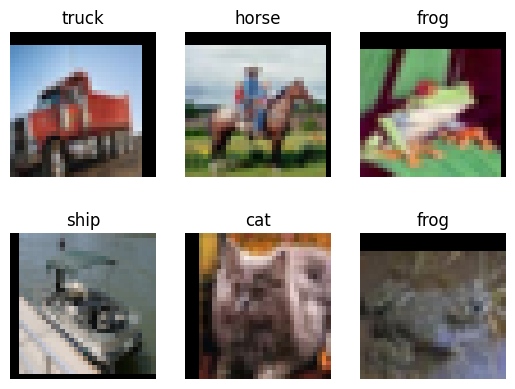

In [25]:
import numpy as np
import matplotlib.pyplot as plt

data = next(ds_train.create_dict_iterator())

images = data["image"].asnumpy()
labels = data["label"].asnumpy()
print(f"Image shape: {images.shape}, Label: {labels}")

plt.figure()
for i in range(1, 7):
    plt.subplot(2, 3, i)
    image_trans = np.transpose(images[i - 1], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{dataset_train.index2label[labels[i - 1]]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()

## 构建网络

残差网络结构(Residual Network)是ResNet网络的主要亮点，ResNet使用残差网络结构后可有效地减轻退化问题，实现更深的网络结构设计，提高网络的训练精度。本节首先讲述如何构建残差网络结构，然后通过堆叠残差网络来构建ResNet50网络。

### 构建残差网络结构

残差网络结构图如下图所示，残差网络由两个分支构成：一个主分支，一个shortcuts（图中弧线表示）。主分支通过堆叠一系列的卷积操作得到，shotcuts从输入直接到输出，主分支输出的特征矩阵$F(x)$加上shortcuts输出的特征矩阵$x$得到$F(x)+x$，通过Relu激活函数后即为残差网络最后的输出。

![residual](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/resnet_3.png)

残差网络结构主要由两种，一种是Building Block，适用于较浅的ResNet网络，如ResNet18和ResNet34；另一种是Bottleneck，适用于层数较深的ResNet网络，如ResNet50、ResNet101和ResNet152。

#### Building Block

Building Block结构图如下图所示，主分支有两层卷积网络结构：

+ 主分支第一层网络以输入channel为64为例，首先通过一个$3\times3$的卷积层，然后通过Batch Normalization层，最后通过Relu激活函数层，输出channel为64；
+ 主分支第二层网络的输入channel为64，首先通过一个$3\times3$的卷积层，然后通过Batch Normalization层，输出channel为64。

最后将主分支输出的特征矩阵与shortcuts输出的特征矩阵相加，通过Relu激活函数即为Building Block最后的输出。

![building-block-5](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/resnet_5.png)

主分支与shortcuts输出的特征矩阵相加时，需要保证主分支与shortcuts输出的特征矩阵shape相同。如果主分支与shortcuts输出的特征矩阵shape不相同，如输出channel是输入channel的一倍时，shortcuts上需要使用数量与输出channel相等，大小为$1\times1$的卷积核进行卷积操作；若输出的图像较输入图像缩小一倍，则要设置shortcuts中卷积操作中的`stride`为2，主分支第一层卷积操作的`stride`也需设置为2。

如下代码定义`ResidualBlockBase`类实现Building Block结构。

In [3]:
from typing import Type, Union, List, Optional
from mindvision.classification.models.blocks import ConvNormActivation
from mindspore import nn


class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # 最后一个卷积核数量与第一个卷积核数量相等

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            norm = nn.BatchNorm2d

        self.conv1 = ConvNormActivation(in_channel, out_channel,
                                        kernel_size=3, stride=stride, norm=norm)
        self.conv2 = ConvNormActivation(out_channel, out_channel,
                                        kernel_size=3, norm=norm, activation=None)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcuts分支

        out = self.conv1(x)  # 主分支第一层：3*3卷积层
        out = self.conv2(out)  # 主分支第二层：3*3卷积层

        if self.down_sample:
            identity = self.down_sample(x)
        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

In [4]:
from typing import Type, Union, List, Optional
# from mindvision.classification.models.blocks import ConvNormActivation
from mindspore import nn

class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # 最后一个卷积核数量与第一个卷积核数量相等

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d
        else:
            self.norm = norm
            
        self.conv1 = nn.Conv2d(in_channel, out_channel,
                              kernel_size=3, stride=stride)
        self.conv2 = nn.Conv2d(in_channel, out_channel,
                              kernel_size=3)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcuts分支

        out = self.conv1(x)  # 主分支第一层：3*3卷积层
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm(out)
            
        if self.down_sample:
            identity = self.down_sample(x)
        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out


#### Bottleneck

Bottleneck结构图如下图所示，在输入相同的情况下Bottleneck结构相对Building Block结构的参数数量更少，更适合层数较深的网络，ResNet50使用的残差结构就是Bottleneck。该结构的主分支有三层卷积结构，分别为$1\times1$的卷积层、$3\times3$卷积层和$1\times1$的卷积层，其中$1\times1$的卷积层分别起降维和升维的作用。

+ 主分支第一层网络以输入channel为256为例，首先通过数量为64，大小为$1\times1$的卷积核进行降维，然后通过Batch Normalization层，最后通过Relu激活函数层，其输出channel为64；
+ 主分支第二层网络通过数量为64，大小为$3\times3$的卷积核提取特征，然后通过Batch Normalization层，最后通过Relu激活函数层，其输出channel为64；
+ 主分支第三层通过数量为256，大小$1\times1$的卷积核进行升维，然后通过Batch Normalization层，其输出channel为256。

最后将主分支输出的特征矩阵与shortcuts输出的特征矩阵相加，通过Relu激活函数即为Bottleneck最后的输出。

![building-block-6](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/resnet_6.png)

主分支与shortcuts输出的特征矩阵相加时，需要保证主分支与shortcuts输出的特征矩阵shape相同。如果主分支与shortcuts输出的特征矩阵shape不相同，如输出channel是输入channel的一倍时，shortcuts上需要使用数量与输出channel相等，大小为$1\times1$的卷积核进行卷积操作；若输出的图像较输入图像缩小一倍，则要设置shortcuts中卷积操作中的`stride`为2，主分支第二层卷积操作的`stride`也需设置为2。

如下代码定义`ResidualBlock`类实现Bottleneck结构。

In [4]:
class ResidualBlock(nn.Cell):
    expansion = 4  # 最后一个卷积核的数量是第一个卷积核数量的4倍

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()
        if not norm:
            norm = nn.BatchNorm2d

        self.conv1 = ConvNormActivation(in_channel, out_channel,
                                        kernel_size=1, norm=norm)
        self.conv2 = ConvNormActivation(out_channel, out_channel,
                                        kernel_size=3, stride=stride, norm=norm)
        self.conv3 = ConvNormActivation(out_channel, out_channel * self.expansion,
                                        kernel_size=1, norm=norm, activation=None)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        identity = x  # shortscuts分支

        out = self.conv1(x)  # 主分支第一层：1*1卷积层
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.conv3(out)  # 主分支第三层：1*1卷积层

        if self.down_sample:
            identity = self.down_sample(x)

        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

In [5]:
class ResidualBlock(nn.Cell):
    expansion = 4  # 最后一个卷积核的数量是第一个卷积核数量的4倍

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d
        else:
            self.norm = norm
            
        self.conv1 = nn.Conv2d(in_channel, out_channel, 
                               kernel_size=1)
        self.conv2 = nn.Conv2d(out_channel, out_channel, 
                               kernel_size=3, stride=stride)
        self.conv3 = nn.Conv2d(out_channel, out_channel * self.expansion, 
                               kernel_size=1)

        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        identity = x  # shortscuts分支

        out = self.conv1(x)  # 主分支第一层：1*1卷积层
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv3(out)  # 主分支第三层：1*1卷积层
        out = self.norm(out)

        if self.down_sample:
            identity = self.down_sample(x)

        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

#### 构建ResNet50网络

ResNet网络层结构如下图所示，以输入彩色图像$224\times224$为例，首先通过数量64，卷积核大小为$7\times7$，stride为2的卷积层conv1，该层输出图片大小为$112\times112$，输出channel为64；然后通过一个$3\times3$的最大下采样池化层，该层输出图片大小为$56\times56$，输出channel为64；再堆叠4个残差网络块（conv2_x、conv3_x、conv4_x和conv5_x），此时输出图片大小为$7\times7$，输出channel为2048；最后通过一个平均池化层、全连接层和softmax，得到分类概率。

![resnet-layer](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/application/source_zh_cn/cv/images/resnet_2.png)

对于每个残差网络块，以ResNet50网络中的conv2_x为例，其由3个Bottleneck结构堆叠而成，每个Bottleneck输入的channel为64，输出channel为256。

如下示例定义`make_layer`实现残差块的构建，其参数如下所示:

+ `last_out_channel`：上一个残差网络输出的通道数。
+ `block`：残差网络的类别，分别为`ResidualBlockBase`和`ResidualBlock`。
+ `channel`：残差网络输入的通道数。
+ `block_nums`：残差网络块堆叠的个数。
+ `stride`：卷积移动的步幅。

In [5]:
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts分支

    if stride != 1 or last_out_channel != channel * block.expansion:
        down_sample = ConvNormActivation(last_out_channel, channel * block.expansion,
                                         kernel_size=1, stride=stride, norm=nn.BatchNorm2d, activation=None)

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample, norm=nn.BatchNorm2d))

    in_channel = channel * block.expansion
    # 堆叠残差网络
    for _ in range(1, block_nums):
        layers.append(block(in_channel, channel, norm=nn.BatchNorm2d))

    return nn.SequentialCell(layers)

In [6]:
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts分支

    if stride != 1 or last_out_channel != channel * block.expansion:
        down_sample = nn.SequentialCell([
            nn.Conv2d(last_out_channel, channel * block.expansion,
                               kernel_size=1, stride=stride),
            nn.BatchNorm2d(channel * block.expansion)
        ])

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample, norm=nn.BatchNorm2d))

    in_channel = channel * block.expansion
    # 堆叠残差网络
    for _ in range(1, block_nums):
        layers.append(block(in_channel, channel, norm=nn.BatchNorm2d))

    return nn.SequentialCell(layers)

ResNet50网络共有5个卷积结构，一个平均池化层，一个全连接层，以CIFAR-10数据集为例：

+ **conv1**：输入图片大小为$32\times32$，输入channel为3。首先经过一个卷积核数量为64，卷积核大小为$7\times7$，stride为2的卷积层；然后通过一个Batch Normalization层；最后通过Reul激活函数。该层输出feature map大小为$16\times16$，输出channel为64。
+ **conv2_x**：输入feature map大小为$16\times16$，输入channel为64。首先经过一个卷积核大小为$3\times3$，stride为2的最大下采样池化操作；然后堆叠3个$[1\times1，64；3\times3，64；1\times1，256]$结构的Bottleneck。该层输出feature map大小为$8\times8$，输出channel为256。
+ **conv3_x**：输入feature map大小为$8\times8$，输入channel为256。该层堆叠4个[1×1，128；3×3，128；1×1，512]结构的Bottleneck。该层输出feature map大小为$4\times4$，输出channel为512。
+ **conv4_x**：输入feature map大小为$4\times4$，输入channel为512。该层堆叠6个[1×1，256；3×3，256；1×1，1024]结构的Bottleneck。该层输出feature map大小为$2\times2$，输出channel为1024。
+ **conv5_x**：输入feature map大小为$2\times2$，输入channel为1024。该层堆叠3个[1×1，512；3×3，512；1×1，2048]结构的Bottleneck。该层输出feature map大小为$1\times1$，输出channel为2048。
+ **average pool & fc**：输入channel为2048，输出channel为分类的类别数。

如下示例代码实现ResNet50模型的构建，通过用调函数`resnet50`即可构建ResNet50模型，函数`resnet50`参数如下：

+ `num_classes`：分类的类别数，默认类别数为1000。
+ `pretrained`：下载对应的训练模型，并加载预训练模型中的参数到网络中。

In [6]:
from mindvision.classification.models.classifiers import BaseClassifier
from mindvision.classification.models.head import DenseHead
from mindvision.classification.models.neck import GlobalAvgPooling
from mindvision.classification.utils.model_urls import model_urls
from mindvision.utils.load_pretrained_model import LoadPretrainedModel


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], norm: Optional[nn.Cell] = None) -> None:
        super(ResNet, self).__init__()
        if not norm:
            norm = nn.BatchNorm2d
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64
        self.conv1 = ConvNormActivation(3, 64, kernel_size=7, stride=2, norm=norm)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义，
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)

    def construct(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x


def _resnet(arch: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, input_channel: int):
    backbone = ResNet(block, layers)
    neck = GlobalAvgPooling()  # 平均池化层
    head = DenseHead(input_channel=input_channel, num_classes=num_classes)  # 全连接层
    model = BaseClassifier(backbone, neck, head)  # 将backbone层、neck层和head层连接起来

    if pretrained:
        # 下载并加载预训练模型
        LoadPretrainedModel(model, model_urls[arch]).run()

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    "ResNet50模型"
    return _resnet("resnet50", ResidualBlock, [3, 4, 6, 3], num_classes, pretrained, 2048)

In [8]:
import os
import tqdm
import hashlib
import urllib
import urllib.error
import urllib.request

from mindspore import load_checkpoint, load_param_into_net



class LoadPretrainedModel():
    """load pretrained model from url"""

    USER_AGENT: str = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) " \
                      "Chrome/92.0.4515.131 Safari/537.36"

    def __init__(self, model, url):
        self.model = model
        self.url = url
        self.path = os.path.join('./', self.__class__.__name__)

    def calculate_md5(file_path: str, chunk_size: int = 1024 * 1024) -> str:
        """Calculate md5 value."""
        md5 = hashlib.md5()
        with open(file_path, 'rb') as fp:
            for chunk in iter(lambda: fp.read(chunk_size), b''):
                md5.update(chunk)
        return md5.hexdigest()

    def check_md5(self, file_path: str, md5: Optional[str] = None) -> bool:
        """Check md5 value."""
        return md5 == self.calculate_md5(file_path)

    def download_url(self,
                     url: str,
                     path: str = './',
                     filename: Optional[str] = None,
                     md5: Optional[str] = None,
                     chunk_size: int = 1024) -> None:
        """Download a file from a url and place it in root."""
        path = os.path.expanduser(path)
        os.makedirs(path, exist_ok=True)

        if not filename:
            filename = os.path.basename(url)

        file_path = os.path.join(path, filename)

        # Check if the file is exists.
        if os.path.isfile(file_path):
            if not md5 or self.check_md5(file_path, md5):
                return

        # Define request headers.
        headers = {"User-Agent": self.USER_AGENT}

        # Download the file.
        try:
            with open(file_path, 'wb') as f:
                request = urllib.request.Request(url, headers=headers)
                with urllib.request.urlopen(request) as response:
                    with tqdm(total=response.length, unit='B') as pbar:
                        for chunk in iter(lambda: response.read(chunk_size), b''):
                            if not chunk:
                                break
                            pbar.update(chunk_size)
                            f.write(chunk)
        except (urllib.error.URLError, IOError) as e:
            raise e

    def download_checkpoint_from_url(self):
        """Download the checkpoint if it doesn't exist already."""
        os.makedirs(self.path, exist_ok=True)

        # download files
        self.download_url(self.url, path=self.path)

    def load_checkpoint(self):
        """Load checkpoint."""
        self.param_dict = load_checkpoint(os.path.join(self.path, os.path.basename(self.url)))

    def load_param_into_net(self):
        load_param_into_net(self.model, self.param_dict)

    def run(self):
        """Download checkpoint file and load it."""
        self.download_checkpoint_from_url()
        self.load_checkpoint()
        self.load_param_into_net()


In [9]:
from mindvision.classification.utils.model_urls import model_urls


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], norm: Optional[nn.Cell] = None) -> None:
        super(ResNet, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d
        else:
            self.norm = norm
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义，
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)

    def construct(self, x):
        x = self.conv1(x)
        x = self.norm(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x


def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, input_channel: int):
    backbone = ResNet(block, layers)
    
    neck = nn.AvgPool2d(kernel_size=7)
    head = nn.Dense(in_channels=input_channel, out_channels=num_classes)
    model = head(neck(backbone))  # 将backbone层、neck层和head层连接起来

    if pretrained:
        # 下载并加载预训练模型
        LoadPretrainedModel(model, model_url).run()

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    "ResNet50模型"
    resnet50_url = "https://download.mindspore.cn/vision/classification/resnet50_224.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes, pretrained, 2048)

## 模型训练与评估

本节使用[ResNet50预训练模型](https://download.mindspore.cn/vision/classification/resnet50_224.ckpt)进行微调。调用`resnet50`构造ResNet50模型，并设置`pretrained`参数为True，将会自动下载ResNet50预训练模型，并加载预训练模型中的参数到网络中。然后定义优化器和损失函数，通过`model.train`接口对网络进行训练，将MindSpore Vision中的`mindvision.engine.callback.ValAccMonitor`接口传入回调函数中，将会打印训练的损失值和评估精度，并保存评估精度最高的ckpt文件（best.ckpt）到当前目录下。

In [ ]:
import mindspore as ms
from mindvision.engine.callback import ValAccMonitor

# 定义ResNet50网络
network = resnet50(pretrained=True)

# 全连接层输入层的大小
in_channel = network.head.dense.in_channels
head = DenseHead(input_channel=in_channel, num_classes=10)
# 重置全连接层
network.head = head
# 设置学习率
num_epochs = 40
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size * num_epochs,
                        step_per_epoch=step_size, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# 实例化模型
model = ms.Model(network, loss, opt, metrics={"Accuracy": nn.Accuracy()})
# 模型训练
model.train(num_epochs, ds_train, callbacks=[ValAccMonitor(model, ds_val, num_epochs)])

In [ ]:
import mindspore as ms 
# 定义ResNet50网络
network = resnet50(pretrained=True)

# 全连接层输入层的大小
in_channel = network.head.dense.in_channels
head = DenseHead(input_channel=in_channel, num_classes=10)
# 重置全连接层
network.head = head

# 设置学习率
num_epochs = 40
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size * num_epochs,
                        step_per_epoch=step_size, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

def forward_fn(inputs, targets):
    logits = network()




def train_step()


for epoch in range(40):


```Text
--------------------
Epoch: [  0 /  40], Train Loss: [2.733], Accuracy:  0.274
--------------------
Epoch: [  1 /  40], Train Loss: [2.877], Accuracy:  0.319
--------------------
Epoch: [  2 /  40], Train Loss: [2.438], Accuracy:  0.249
--------------------
Epoch: [  3 /  40], Train Loss: [1.532], Accuracy:  0.386

······

Epoch: [ 37 /  40], Train Loss: [1.142], Accuracy:  0.738
--------------------
Epoch: [ 38 /  40], Train Loss: [0.402], Accuracy:  0.727
--------------------
Epoch: [ 39 /  40], Train Loss: [2.031], Accuracy:  0.735
--------------------
Epoch: [ 40 /  40], Train Loss: [0.582], Accuracy:  0.745
================================================================================
End of validation the best Accuracy is:  0.754, save the best ckpt file in ./best.ckpt

```

## 可视化模型预测

定义`visualize_model`函数，使用上述验证精度最高的模型对CIFAR-10测试数据集进行预测，并将预测结果可视化。若预测字体颜色为蓝色表示为预测正确，预测字体颜色为红色则表示预测错误。

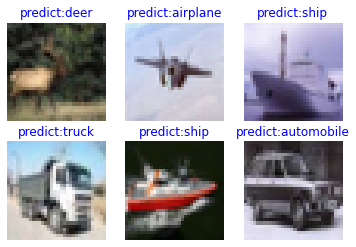

In [9]:
import matplotlib.pyplot as plt


def visualize_model(best_ckpt_path, val_ds):
    num_class = 10  # 对狼和狗图像进行二分类
    net = resnet50(num_class)
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)
    # 加载验证集的数据进行验证
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    # 预测图像类别
    output = model.predict(ms.Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(1, 7):
        plt.subplot(2, 3, i)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i - 1] == labels[i - 1] else 'red'
        plt.title('predict:{}'.format(dataset_val.index2label[pred[i - 1]]), color=color)
        picture_show = np.transpose(images[i - 1], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

# 使用测试数据集进行验证
visualize_model('best.ckpt', ds_val)